In [1]:
import zipfile
import os
import pandas as pd
import plotly.express as px

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['ocupacao']=df['ocupacao'].str.replace('PF - ','')
            df['modalidade']=df['modalidade'].str.replace('PF - ','')
            df['mes'] = df['data_base'].dt.month #cria uma nova coluna com mês
             
            #Filtros:
            df = df[df['cliente'] == 'PF']
            df = df[df['mes'] == 12]
            df = df[['data_base', 'ocupacao', 'modalidade', 'carteira_ativa']]
            
            #Agrupamentos para análise
            df = df.groupby(['data_base', 'ocupacao', 'modalidade'])['carteira_ativa'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [4]:
df_total.head()

,data_base,ocupacao,modalidade,carteira_ativa
0,2012-12-31,Aposentado/pensionista,Cartão de crédito,6.766961e+09
1,2012-12-31,Aposentado/pensionista,Empréstimo com consignação em folha,2.587770e+10
2,2012-12-31,Aposentado/pensionista,Empréstimo sem consignação em folha,7.389643e+09
3,2012-12-31,Aposentado/pensionista,Habitacional,3.963284e+09
4,2012-12-31,Aposentado/pensionista,Outros créditos,3.512544e+09


In [5]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 55
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data_base       608 non-null    datetime64[ns]
 1   ocupacao        608 non-null    object        
 2   modalidade      608 non-null    object        
 3   carteira_ativa  608 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 23.8+ KB


In [6]:
df_total.to_csv("pf_ocupacao_modalidade_endividamento_final.csv")

In [7]:
import deflatebr as dbr

In [8]:
df_total['carteira_ativa_deflacionada'] = dbr.deflate(nominal_values=df_total['carteira_ativa'], nominal_dates=df_total['data_base'], real_date='2022-01')

C:\Users\ticia\anaconda3\lib\site-packages\deflatebr\deflate.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['deflated'] = df[['nom_values', 'VALVALOR']].apply(lambda x: ((real_indx/x[1]) * x[0])[0], axis=1)


In [9]:
df_total.head(3)

,data_base,ocupacao,modalidade,carteira_ativa,carteira_ativa_deflacionada
0,2012-12-31,Aposentado/pensionista,Cartão de crédito,6.766961e+09,1.164946e+10
1,2012-12-31,Aposentado/pensionista,Empréstimo com consignação em folha,2.587770e+10,4.454896e+10
2,2012-12-31,Aposentado/pensionista,Empréstimo sem consignação em folha,7.389643e+09,1.272142e+10


In [10]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_total.head(3)

,data_base,ocupacao,modalidade,carteira_ativa,carteira_ativa_deflacionada
0,2012-12-31,Aposentado/pensionista,Cartão de crédito,6766960907.56,11649456242.40
1,2012-12-31,Aposentado/pensionista,Empréstimo com consignação em folha,25877695111.32,44548960895.67
2,2012-12-31,Aposentado/pensionista,Empréstimo sem consignação em folha,7389642595.93,12721415010.99


C:\Users\ticia\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



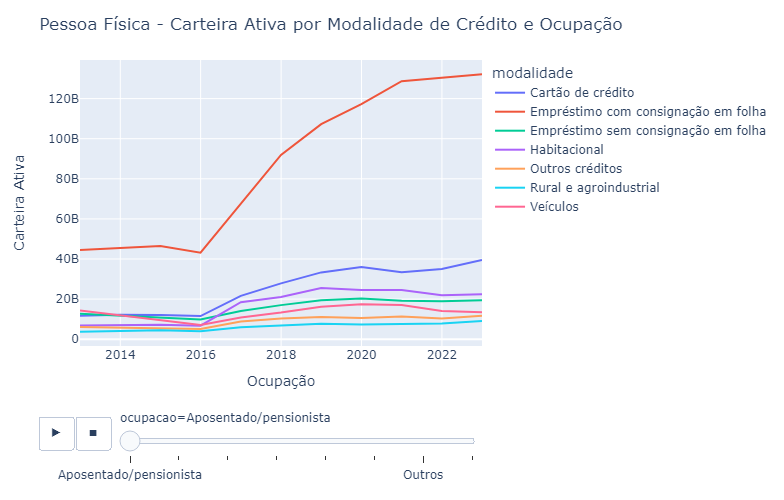

In [14]:
fig = px.line(df_total, 
             x='data_base',
             y='carteira_ativa_deflacionada', 
             color='modalidade', 
             animation_frame='ocupacao')

fig.update_layout(title_text='Pessoa Física - Carteira Ativa por Modalidade de Crédito e Ocupação',
             xaxis_title='Ocupação',
             yaxis_title='Carteira Ativa',
             height=500, 
             width=800)

fig.show()